## Install Package

In [ ]:
!pip install mlconfgen

## Download the weights from HuggingFace
> https://huggingface.co/Membrizard/ml_conformer_generator

`edm_moi_chembl_15_39.pt`

`adj_mat_seer_chembl_15_39.pt`

## Generate Molecules using a Reference Molecule and evaluate results (PyTorch)

Intitialising model on mps:0
Generation started...
Generation complete in 26.37


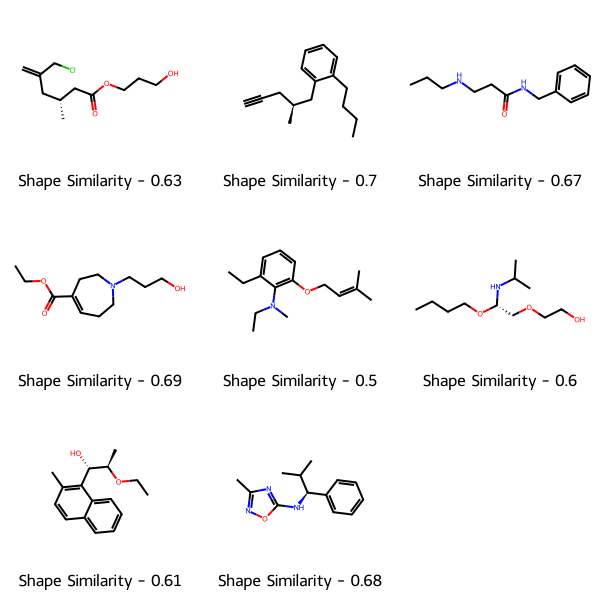

In [2]:
import time
import torch

from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem import Draw

from mlconfgen import MLConformerGenerator, evaluate_samples


RDLogger.DisableLog('rdApp.*')

if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps:0")
else:
    device = torch.device("cpu")

print(f"Intitialising model on {device}")
    
generator = MLConformerGenerator(
                                 edm_weights="./edm_moi_chembl_15_39.pt",
                                 adj_mat_seer_weights="./adj_mat_seer_chembl_15_39.pt",
                                 device=device,
                                 diffusion_steps=100,
                                )

# Load a Reference conformer
ref_mol = Chem.MolFromMolFile('./demo_files/ceyyag.mol')


# Generate Samples
print("Generation started...")
start = time.time()
samples = generator.generate_conformers(reference_conformer=ref_mol, n_samples=10, variance=2)
print(f"Generation complete in {round(time.time() - start, 2)}")

# Characterise samples   
_, std_samples = evaluate_samples(ref_mol, samples)

# Display results
mols = []
legends = []
for sample in std_samples:
    mol = Chem.MolFromMolBlock(sample['mol_block'])
    mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    mol.SetProp("Shape_Tanimoto", str(sample['shape_tanimoto']))
    mols.append(mol)
    legends.append(f"Shape Similarity - {round(sample['shape_tanimoto'], 2)}")
    
Draw.MolsToGridImage(mols, legends=legends)

## Generate Molecules using an arbitrary shape (protein pocket) 
requires trimesh >= 4.6.4 library to be installed 

In [ ]:
!pip install trimesh

Intitialising model on mps:0
Generation started...
Generation complete in 108.06


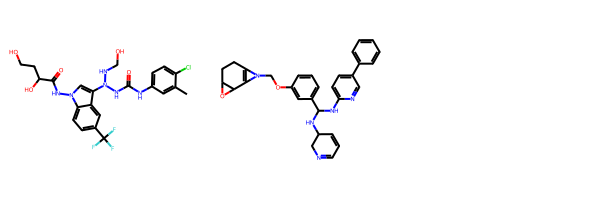

In [3]:
import time
import torch
import trimesh

from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem import Draw
from rdkit import RDLogger

from mlconfgen import MLConformerGenerator


if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps:0")
else:
    device = torch.device("cpu")

print(f"Intitialising model on {device}")

# Load example - CLK1 pocket as .stl file
mymesh = trimesh.load('./demo_files/6q8k_pocket.stl')
mymesh.density = 0.02

# The shape that you are using needs to be watertight
check = mymesh.is_watertight

if not check:
    raise ValueError("The .stl file needs to be watertight.")

ref_context = torch.tensor(mymesh.principal_inertia_components, dtype=torch.float32)

generator = MLConformerGenerator(
                                 edm_weights="./edm_moi_chembl_15_39.pt",
                                 adj_mat_seer_weights="./adj_mat_seer_chembl_15_39.pt",
                                 device=device,
                                 diffusion_steps=100,
                                )

# Generate Samples
print("Generation started...")
start = time.time()
samples = generator.generate_conformers(reference_context=ref_context, n_atoms=38, n_samples=10, variance=1)
print(f"Generation complete in {round(time.time() - start, 2)}")

# Display results
mols = [Chem.MolFromSmiles(Chem.MolToSmiles(x)) for x in samples]

Draw.MolsToGridImage(mols)

## Generate Molecules using a Reference Molecule (ONNX)

additional dependencies required:
onnx==1.17.0
onnxruntime==1.21.0


### Download the weights in the ONNX format from HuggingFace
> https://huggingface.co/Membrizard/ml_conformer_generator

`egnn_chembl_15_39.onnx`

`adj_mat_seer_chembl_15_39.onnx`

Generation started...
Generation complete in 110.83


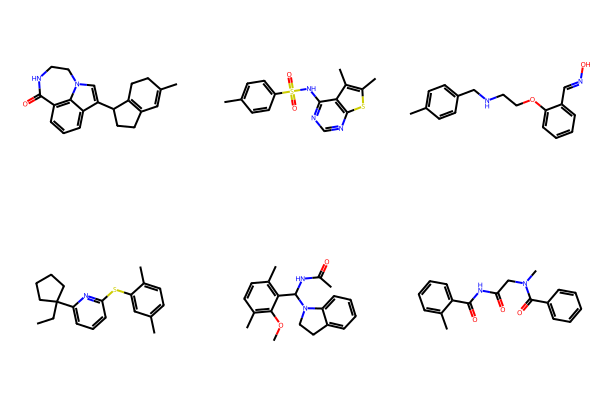

In [2]:
import time

from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem import Draw

from mlconfgen import MLConformerGeneratorONNX

RDLogger.DisableLog('rdApp.*')
    
generator = MLConformerGeneratorONNX(
                                     egnn_onnx="./egnn_chembl_15_39.onnx",
                                     adj_mat_seer_onnx="./adj_mat_seer_chembl_15_39.onnx",
                                    )

# Load a Reference conformer
ref_mol = Chem.MolFromMolFile('./demo_files/yibfeu.mol')

# Generate Samples
print("Generation started...")
start = time.time()
samples = generator.generate_conformers(reference_conformer=ref_mol, n_samples=10, variance=2)
print(f"Generation complete in {round(time.time() - start, 2)}")

# Display results
mols = [Chem.MolFromSmiles(Chem.MolToSmiles(x)) for x in samples]
    
Draw.MolsToGridImage(mols)